# Testing and visulization of the projection matrix

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Load the projection matrix and points

In [4]:
project = "Ch4_demo"
points_3D = np.load(f"../../inference_data/projection_matrix/{project}/points/points_3D.npy")
points_2D = np.load(f"../../inference_data/projection_matrix/{project}/points/points_2D.npy")
P = np.load(f"../../inference_data/projection_matrix/{project}/projection_matrix.npy")
P_inv = np.load(f"../../inference_data/projection_matrix/{project}/projection_matrix_inv.npy")
camera_origin = np.load(f"../../inference_data/projection_matrix/{project}/camera_origin.npy")

In [8]:
P

array([[-1.20144418e+00,  8.67336410e-01,  2.79089415e-01,
        -4.42064109e+02],
       [ 9.53144446e-03, -1.18886665e-01,  9.79261180e-01,
        -1.10155729e+02],
       [ 9.51450351e-05,  1.80513415e-03,  5.62514363e-04,
        -1.55907863e+00]])

## Evaluate

In [9]:
def evaluate_points(M, Points_2D, Points_3D):

    reshaped_points = np.concatenate(
        (Points_3D, np.ones((Points_3D.shape[0], 1))), axis=1)
    Projection = np.matmul(M, np.transpose(reshaped_points))
    Projection = np.transpose(Projection)
    u = np.divide(Projection[:, 0], Projection[:, 2])
    v = np.divide(Projection[:, 1], Projection[:, 2])
    Residual = np.sum(
        np.power(
            np.power(u - Points_2D[:, 0], 2) +
            np.power(v - Points_2D[:, 1], 2), 0.5))
    Projected_2D_Pts = np.transpose(np.vstack([u, v]))

    return Projected_2D_Pts, Residual

In [10]:

def visualize_points(Actual_Pts, Project_Pts):
    plt.scatter(Actual_Pts[:, 0], Actual_Pts[:, 1], marker='o')
    plt.scatter(Project_Pts[:, 0], Project_Pts[:, 1], marker='x')
    plt.legend(('Actual Points', 'Projected Points'))
    plt.show()

In [11]:
pts, res = evaluate_points(P, points_2D, points_3D)
print(res)

271.7248607174445


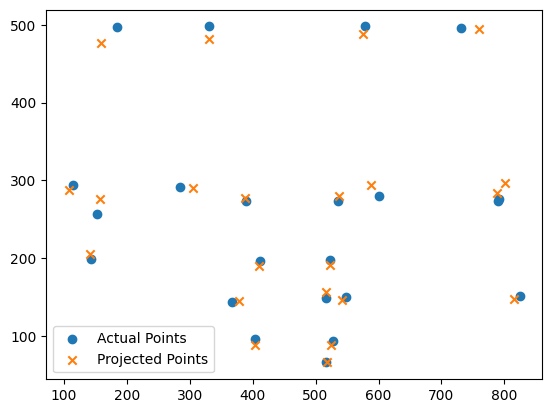

In [12]:
visualize_points(points_2D, pts)

## Camera Origin

In [15]:
def plot3dview(Points_3D, camera_origin):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Points_3D[:, 0],
               Points_3D[:, 1],
               Points_3D[:, 2],
               c='b',
               marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.elev = 31
    ax.azim = -129

    # draw vertical lines connecting each point to Z=0
    min_z = np.min(Points_3D[:, 2])
    for i in range(0, Points_3D.shape[0]):
        ax.plot(np.array([Points_3D[i, 0], Points_3D[i, 0]]),
                np.array([Points_3D[i, 1], Points_3D[i, 1]]),
                np.array([Points_3D[i, 2], min_z]))

    # if camera_origin exists, plot it
    if 'camera_origin' in locals():
        ax.scatter(camera_origin[0],
                   camera_origin[1],
                   camera_origin[2],
                   s=100,
                   c='r',
                   marker='x')
        ax.plot(np.array([camera_origin[0], camera_origin[0]]),
                np.array([camera_origin[1], camera_origin[1]]),
                np.array([camera_origin[2], min_z]),
                c='r')

    plt.show()

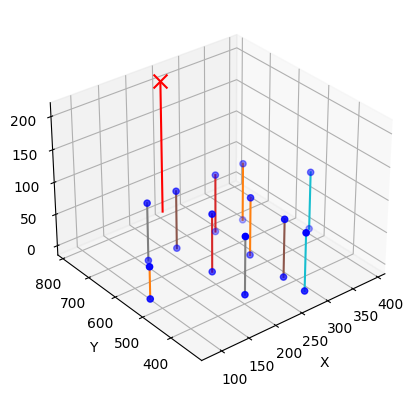

In [16]:
plot3dview(points_3D, camera_origin)

## Visualize Mapping

In [54]:
def project_2D_to_3D(P_inv, camera_origin, point_2D, height):
    """Project 2D point to 3D space.
    Args:
        P_inv (np.ndarray): Inverse of projection matrix.
        camera_origin (np.ndarray): Camera origin in 3D space.
        points_2D (np.ndarray): 2D point to project.
        height (float): Height of projected point.
    Returns:
        np.ndarray: 3D points.
    """
    point_2D_h = np.concatenate((point_2D, np.ones((point_2D.shape[0],1))), axis=1)
    point_3D_h = P_inv @ point_2D_h.T
    point_3D = (point_3D_h / point_3D_h[3])[:3].T
    ray_3D = point_3D - camera_origin
    t = (height - camera_origin[2]) / ray_3D[:, 2]
    world_point = camera_origin + ray_3D * t
    return world_point.astype(int)

In [55]:
project_2D_to_3D(P_inv, camera_origin, np.array([[731., 496.]]), 0)

array([[320, 641,   0]])

In [ ]:
# Read in the two images
img1 = cv2.imread(f"../../inference_data/projection_matrix/{project}/images/Ch4_image_undistorted_960.png")
img2 = cv2.imread(f"../../inference_data/projection_matrix/{project}/images/Ch4_floor_plan.png")

In [74]:
def select_points(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # Add the selected point to the list of points
        param[0].append([x,y])
        position_floor_plan = project_2D_to_3D(P_inv, camera_origin, np.array([[x, y]]), 100)[0, :2]
        param[1].append(position_floor_plan)


def get_points(img, floor_plan):
    # Create a copy of the image for display purposes
    img_copy = img.copy()
    floor_plan_copy = floor_plan.copy()
    
    # List to store the selected points
    points = []
    transformed_points = []
    
    # Set up the callback function for mouse events
    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", select_points, [points, transformed_points])
    
    # Loop until the user presses the 'q' key
    while True:
        # Show the image
        cv2.imshow("Image", img_copy)
        cv2.imshow("Floor Plan", floor_plan_copy)
        
        # Draw the selected points on the image
        for point in points:
            cv2.circle(img_copy, tuple(point), 5, (0,0,255), -1)

        for point in transformed_points:
            cv2.circle(floor_plan_copy, tuple(point), 5, (0,0,255), -1)
        
        # Check for user input
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break
    
    # Destroy the window
    cv2.destroyAllWindows()

In [75]:
get_points(img1, img2)